# Sampling One Dimensional Probability Distributions

## Change of Variables 

Suppose that we generate a random deviate $x$ and then take some prescribed function of it, $y(x)$. What is the probability distribution $P(y)$ of the new variable $y$? It is determined by the fundamental transformation rule for probabilities:
$$
P(x)dx = P(y)dy = P(y)\left|\frac{dy}{dx}\right|dx, 
$$ 
or 
$$
P(y) = P(x)\left|\frac{dx}{dy}\right|. 
$$

### Example: The Exponential Distribution

As an example consider the uniform distribution, $U(x|0,1)$, 
$$
U(x|0,1) = 
\begin{cases} 
1 & \text{for } 0 \leq x < 1, \\
0 & \text{otherwise}.
\end{cases}
$$
Let $y(x) \equiv -\ln(1-x)$, then 
$$
x(y) = 1 - e^{-y} \quad \text{and} \quad \left|\frac{dx}{dy}\right| = e^{-y},
$$ 
so we get
$$
P(y) = U(x)\left|\frac{dx}{dy}\right| = e^{-y}.
$$
This is the functional form for the **exponential distribution**, which occurs in many physical processes, such as the distribution of waiting times between independent random events, for example the radioactive decay of a nucleus. 

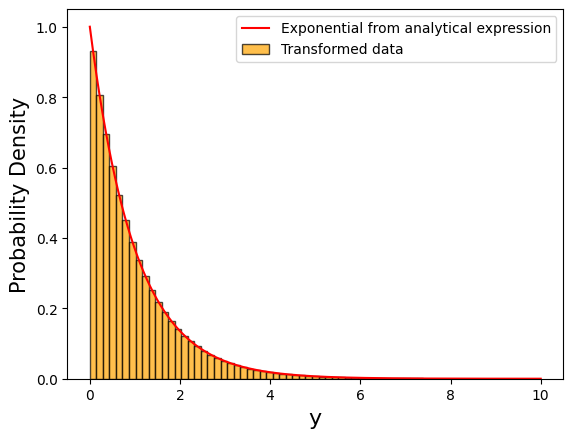

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

# Seed the generator
seed = 42
rng = np.random.default_rng(seed)
# Generate uniform deviates
x = rng.uniform(0,1, 1000000) 

# Transform the uniform deviates to get an exponential distribution for y
y = -np.log(1.0-x)

# Compute the probability density of y using np.histogram
bins = np.linspace(0, 10, 70) # 70 bins from 0 to 10
counts, _ = np.histogram(y, bins=bins, density=True) # return a probability density

# Plot the histogram
plt.bar(bins[:-1], counts, width=np.diff(bins), align='edge', color='orange', alpha=0.7, edgecolor='black', label='Transformed data')

# Compute the exponential distribution function on a finer grid #using scipy.stats.expon
y_fine = np.linspace(0, 10, 1000)
exponential = np.exp(-y_fine) 
#exponential = stats.expon.pdf(y_fine) # same as above but using scipy.stats.expon

# Plot the exponential distribution function
plt.plot(y_fine, exponential, 'r-', label='Exponential from analytical expression')

# Add labels and legend
plt.xlabel('y', fontsize=16)
plt.ylabel('Probability Density', fontsize=15)
plt.legend()
plt.show()

## Sampling From an Arbitrary Probability Distribution

Suppose that we want to draw random samples from some arbitrary probability distribution function $P(y)$, for which there is no function in `numpy.random`.  The fundamental transformation rule for probabilities provides a method for acheiving this. Analogous to 
the example for the exponential distribution above, we need to determine the transformation function $y(x)$, which when applied to draws $x$ from the uniform distribution $U(x|0,1)$, will map it to the desired distribution $P(y)$ via
$$
P(y) = U(x)\left|\frac{dx}{dy}\right|.  
$$
Apparently we just need to solve the differential equation 
$$
\frac{dx}{dy} = P(y). 
$$
But the solution to this is 
$$
x(y) = \int P(y) dy + C,  
$$
where $C$ is a constant of integration.  Notice that aside from the integration constant, the right-hand side of this equation is the cumulative distribution function (CDF) of the distribution we want to sample, $P(y)$. Imagine that $y$ is defined on some domain $y \in (a, b)$, then we can write
$$ 
x(y) = \int_a^y P(y^\prime) dy^\prime + D = {\rm CDF}(\leq y) + D,
$$
where $D$ is another arbitrary constant (we absorbed $C$ into $D$). We can impose the
boundary condition that $x(y=a) = 0$, since the ${\rm CDF}(\leq a) = 0$, allowing us to eliminate the constant of integration  (i.e. $D=0$ given this boundary condition). Thus
$$
x(y) = {\rm CDF}(\leq y) = \int_{a}^y P(y^\prime) dy^\prime. 
$$
The desired variable transformation is then 
<a id='eqn:iCDF'></a>
$$
y(x) = {\rm CDF}^{-1}(x). \tag{6}
$$


<img src="figures/inverse_cdf.png" width="800">


This method is called the **inverse cumulative distribution function method**. It has an immediate geometric interpretation. Since the ${\rm CDF}(\leq y)$ is the area under the curve of $P(y)$ to the left of $y$, eqn.(<a href="#eqn:iCDF">6</a>) just states:
- Draw a random number $x$ from the uniform distribution $U(x|0,1)$.
- Find the value of $y$ that has that fraction $x$ of probability to the left of it
- Return this value of $y$ as the random sample from $P(y)$.


### Example: Sampling from the Triangular Distribution

Suppose that $P(y)$ is the triangular distribution defined by
$$
P(y) = 
\begin{cases} 
2y & \text{for } 0 \leq y \leq 1, \\
0 & \text{otherwise}, 
\end{cases}
$$
then the CDF is
$$
{\rm CDF}(\leq y) = \int_0^y 2y^\prime dy^\prime = y^2. 
$$
Thus
$$
x(y) = {\rm CDF}(\leq y) = y^2 \quad \rightarrow \quad y(x) = {\rm CDF}^{-1}(x) = \sqrt{x}.
$$

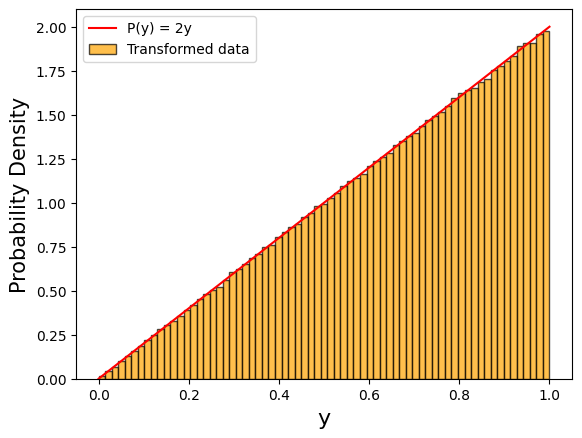

In [2]:
# Generate uniform deviates
x = rng.uniform(0, 1, 1000000)

# Transform the uniform deviates to get a triangular distribution
y = np.sqrt(x)

# Compute the histogram of y
bins = np.linspace(0, 1, 70)
Pofy_hist, _ = np.histogram(y, bins=bins, density=True)

# Plot the histogram
plt.bar(bins[:-1], Pofy_hist, width=np.diff(bins), align='edge', color='orange', alpha=0.7, edgecolor='black', label='Transformed data')

# Compute the triangular distribution function on a finer grid
y_fine = np.linspace(0, 1, 1000)
Pofy = 2*y_fine

# Plot the triangular distribution function
plt.plot(y_fine, Pofy, 'r-', label='P(y) = 2y')

# Add labels and legend
plt.xlabel('y', fontsize=16)
plt.ylabel('Probability Density', fontsize=15)
plt.legend()
plt.show()

Finally, note that even if the integral to determine the CDF cannot be done analytically, it can be done numerically using the `scipy.integrate` module. Under these circumstances you can still use the inverse CDF method to draw random samples from the distribution. Given a numerical expression for ${\rm CDF}(\leq y)$ you perform the inversion to obtain ${\rm CDF}^{-1}(x)$ numerically via **interpolation**. 

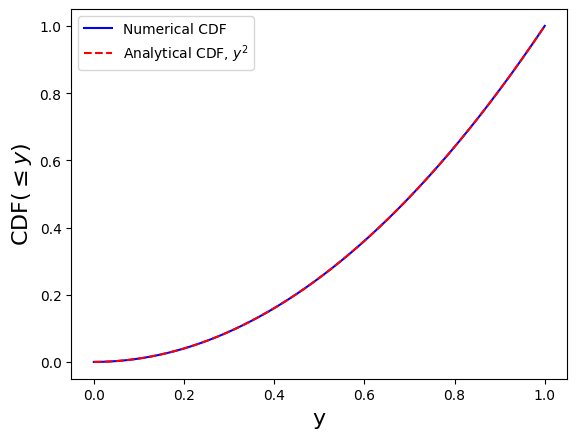

In [3]:
from scipy import integrate, interpolate

# Define the triangular distribution
def triangular(y):
    """
    Function to compute the probability density for the triangular distribution. 
    
    Parameters
    ----------
    y : float or array_like
        The value(s) at which to compute the triangular distribution.
    
    Returns
    -------
    Pofy : float or array_like
        The value(s) of the triangular distribution at y.
    """
    return  2*y*((y >= 0) & (y <= 1))

# Compute the CDF(<=y) of the triangular distribution numerically on fine grid
y_values = np.linspace(0, 1, 1000)
# This list comprehension is a compact way to write a loop that computes the CDF integration at each y. 
cdf_values = [integrate.quad(triangular, 0, y)[0] for y in y_values]

# Plot the CDF and compare to the analytical result
plt.plot(y_values, cdf_values, 'b-', label='Numerical CDF')
plt.plot(y_values, y_values**2, 'r--', label='Analytical CDF, $y^2$')
plt.xlabel('y', fontsize=16)
plt.ylabel(r'${\rm CDF}(\leq y)$', fontsize=16)
plt.legend()
plt.show()


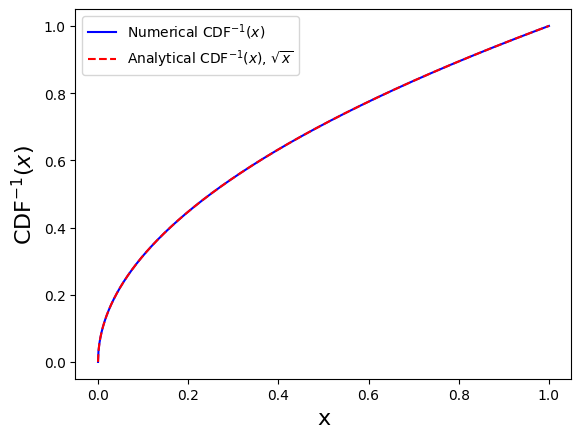

In [4]:
# Now create an interpolation function for the inverse CDF, y = CDF^(-1)(x)
inverse_cdf = interpolate.interp1d(cdf_values, y_values)
# Given a set of x values and y values, the interp1d function returns a function that can be called at any x-values to obtain interpolated 
# y-values, i.e. if you write
# 
# interp_function = interpolate.interp1d(x,z) can evaluat
# z_new = interp_function(x_new)
#
# Since we pass in cdf_values as the x-values and y_values as the z-values,
# the returned function is the inverse CDF, i.e. 
# y_new = inverse_cdf(CDF_new)

# Plot the inverse CDF and compare to the analytical result
x_values = np.linspace(0, 1, 1000)
yofx = inverse_cdf(x_values)
plt.plot(x_values, yofx, 'b-', label=r'Numerical ${\rm CDF}^{-1}(x)$')
plt.plot(x_values, np.sqrt(x_values), 'r--', label=r'Analytical ${\rm CDF}^{-1}(x)$, $\sqrt{x}$')
plt.xlabel('x', fontsize=16)
plt.ylabel(r'${\rm CDF}^{-1}(x)$', fontsize=16)
plt.legend()
plt.show()

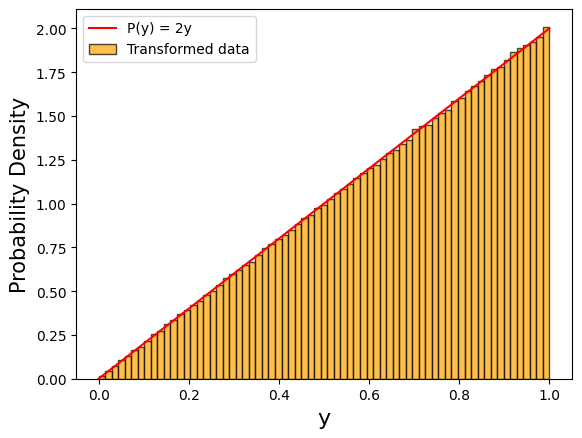

In [5]:
# Now apply the inverse CDF method to generate draws from the triangular distribution P(y) = triangular(y) = 2y
# 
# Generate uniform deviates x between 0 and 1
x = np.random.uniform(0, 1, 1000000)

# Use the inverse CDF method to draw random y samples from P(y)
y_samples = inverse_cdf(x)

# Compute the probability density, P(y), of the y_samples using np.histogram 
bins = np.linspace(0, 1, 70)
counts, _ = np.histogram(y_samples, bins=bins, density=True)

# Plot the histogram
plt.bar(bins[:-1], counts, width=np.diff(bins), align='edge', color='orange', alpha=0.7, edgecolor='black', label='Transformed data')

# Compute the triangular distribution function on a finer grid
y_fine = np.linspace(0, 1, 1000)
Pofy = triangular(y_fine)

# Plot the triangular distribution function
plt.plot(y_fine, Pofy, 'r-', label='P(y) = 2y')

# Add labels and legend
plt.xlabel('y', fontsize=16)
plt.ylabel('Probability Density', fontsize=15)
plt.legend()
plt.show()

In [ ]:
interpolate.interp1d?